In [91]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import sys
sys.path.append('../')
sys.path.append('../keypoints')
from keypoints.cvae.build import forward_keypoint

from mpl_toolkits.mplot3d import Axes3D

In [92]:
def add_noise(x):
    x = x + np.random.normal(size=x.shape) * 0.02
    return x

In [109]:
def visualize_keypoints(point_cloud,
                        keypoints,
                        prefix,
                        name,
                        plot_lim=2,
                        point_size=5):
    [grasp_point, funct_point, funct_vect] = keypoints
    fig = plt.figure(figsize=(6, 6))
    point_cloud = add_noise(point_cloud)
    xs = point_cloud[:, 0]
    ys = point_cloud[:, 1]
    zs = point_cloud[:, 2]

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, s=point_size, c=zs, marker='.', cmap=plt.get_cmap('Greys'))
    ax.set_axis_off()
    ax.grid(False)
    #plt.axis('equal')
    ax.view_init(85, 20)
    plt.savefig(os.path.join(prefix, '{}_point_cloud.png'.format(name)))
    plt.show()

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.scatter(xs, ys, s=point_size, c='#4d4f53', marker='.')
    ax.set_axis_off()
    ax.grid(False)
    
    ax.scatter(grasp_point[:, 0],
               grasp_point[:, 1],
               s=point_size * 30,
               c='#eaab00')
    
    ax.scatter(funct_point[:, 0],
               funct_point[:, 1],
               s=point_size * 30,
               c='#009b76')
    
    ax.scatter(funct_point[:, 0] + funct_vect[:, 0],
               funct_point[:, 1] + funct_vect[:, 1],
               s=point_size * 30,
               c='#007c92')
    plt.axis('equal')
    plt.savefig(os.path.join(prefix, '{}_keypoints.png'.format(name)))
    plt.show()
    plt.close()
    return

In [110]:
MODEL_PATHS = {'hammer': '../keypoints/keypoint_models/cvae_hammer',
               'push': '../keypoints/keypoint_models/cvae_push',
               'reach': '../keypoints/keypoint_models/cvae_reach',}
MAX_PRED_PEROBJ = 2
DATA_PATH = '../keypoints/utils/baseline/data_hammer.hdf5'

data_point_cloud = h5py.File(DATA_PATH, 'r')['pos_point_cloud']

point_cloud_tf = tf.placeholder(tf.float32, [1024, 3])
keypoints, funct_vect, score = forward_keypoint(point_cloud_tf)
grasp_point, funct_point = keypoints

Original shape [256, 1024, 1, 256]
Down sample 1024->16
Down sampled shape [256, 16, 1, 256]


In [115]:
OBJ_INDEX = 0
point_cloud_np = np.squeeze(data_point_cloud[OBJ_INDEX])
point_cloud_np = point_cloud_np - np.mean(point_cloud_np, axis=0, keepdims=True)

INFO:tensorflow:Restoring parameters from ../keypoints/keypoint_models/cvae_hammer


INFO:tensorflow:Restoring parameters from ../keypoints/keypoint_models/cvae_hammer


0


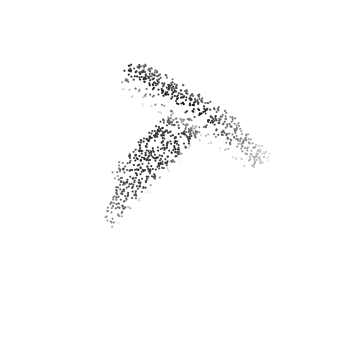

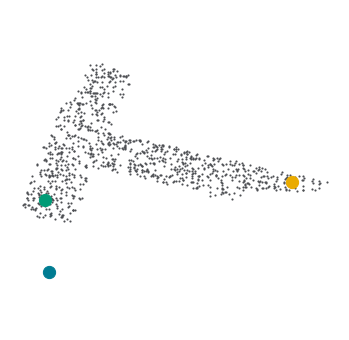

1


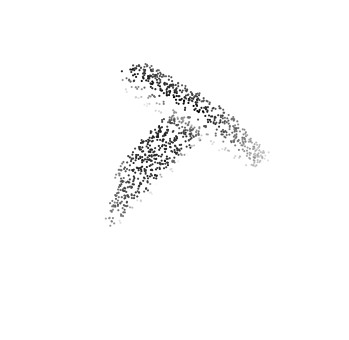

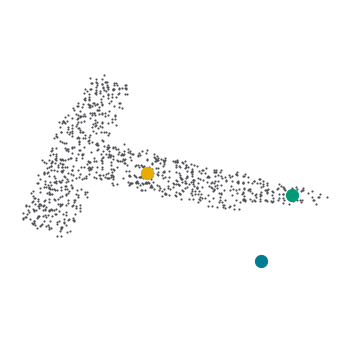

INFO:tensorflow:Restoring parameters from ../keypoints/keypoint_models/cvae_push


INFO:tensorflow:Restoring parameters from ../keypoints/keypoint_models/cvae_push


0


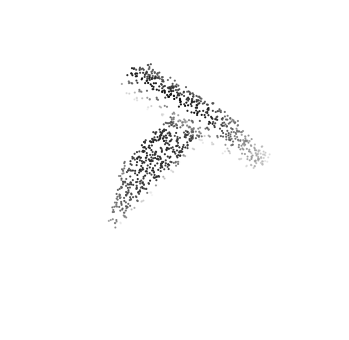

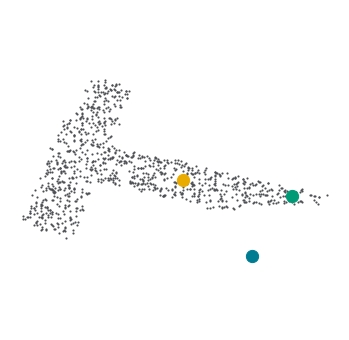

1


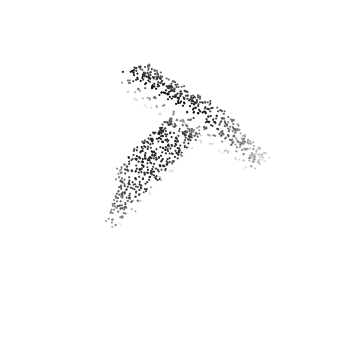

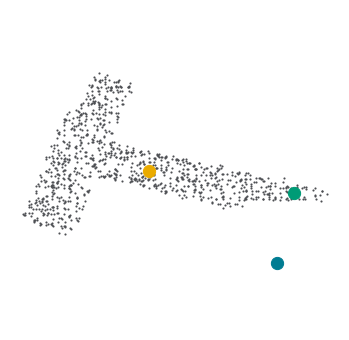

INFO:tensorflow:Restoring parameters from ../keypoints/keypoint_models/cvae_reach


INFO:tensorflow:Restoring parameters from ../keypoints/keypoint_models/cvae_reach


0


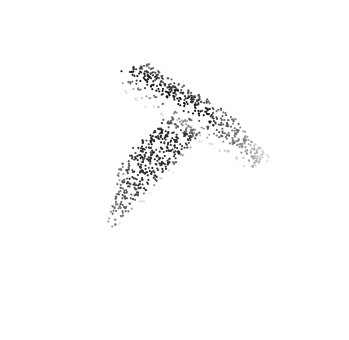

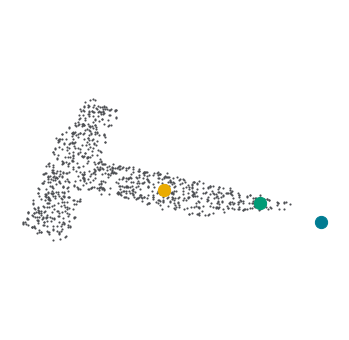

1


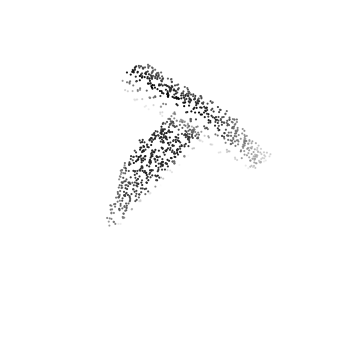

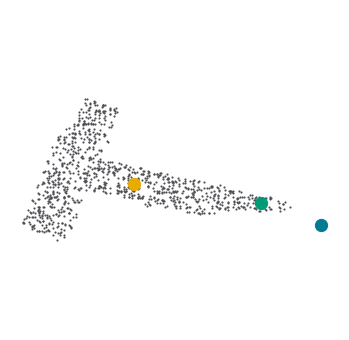

In [116]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    for task in ['hammer', 'push', 'reach']:
        saver.restore(sess, MODEL_PATHS[task])
        for index in range(MAX_PRED_PEROBJ):
            g_np, f_np, fv_np = sess.run([grasp_point, funct_point, funct_vect],
                                         feed_dict={point_cloud_tf: point_cloud_np})
            print(index)
            visualize_keypoints(point_cloud_np, 
                                [g_np, f_np, fv_np],
                                'visualize',
                                '{}_{}'.format(task, index))
            
    